# Solution of the truss problem

First of all the data needs to be declared. These include

- the number of nodes
- the number of elements
- the coordinates of the nodes
- the connectivity of the members
- the element stiffness
- the nodal forces vector
- the boundary conditions

To have consistent units the Young modulus is expressed in [kN/m^2], the area in [m^2] and the length in [m]. This means that the external forces need to be expressed in [kN]. 

The obtained displacement will be expressed in [m] and the reaction forces are also expressed in [kN].

The following code declares the data for the problem



In [1]:
import numpy as np

A = 4000 * 1e-6 # m^2
E = 70 * 1e6 # kPa

EA = A * E

L_1 = 6 # m
L_2 = 4 # m
H = 8 # m

# The nodes are numbered from the bottom to the top, from the left to the right

node_1 = np.array([0, 0])
node_2 = np.array([L_1 + L_2, 0])
node_3 = np.array([0, H])
node_4 = np.array([L_1, H])

coordinates = np.vstack((node_1, node_2, node_3, node_4))

connectivity_table = np.array([[1, 3],
                            [3, 4],
                            [1, 4],
                            [2, 3],
                            [2, 4]]) - 1 # -1 because of python convention

n_nodes = coordinates.shape[0]
n_elements = connectivity_table.shape[0]

n_dofs = n_nodes * 2

# Dictionary containing information on the force value at solicitated nodes
dict_forces_1 = {3: np.array([0, - 400]),
               4: np.array([800, - 400])}

f_1 = np.zeros(n_dofs)

for node, force_node in dict_forces_1.items():
    node_id = node - 1
    f_1[2*node_id:2*node_id+2] = force_node


# Node 1 fixes the x, y displacement. Node 3 fixes the x displacement
dofs_bcs = [0, 1, 2, 3, 4]

Then the second part consists in assembling the stiffness matrix. First of all we verify that the mesh is correct by plotting the different elements    

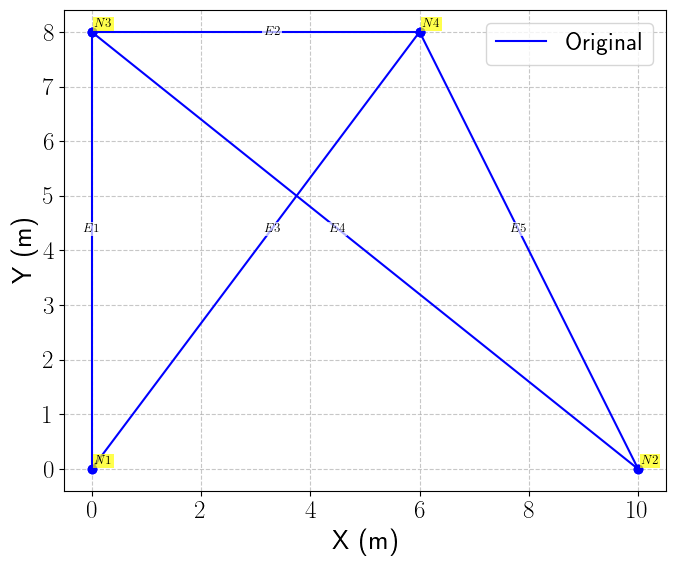

In [2]:
from src.plot_mesh import plot_truss_structure
from matplotlib import pyplot as plt

ax = plot_truss_structure(coordinates, connectivity_table,
        show_element_labels=True,
        show_node_labels=True,
        color='blue',
        linestyle='o-',
        label='Original',
        xlabel='X (m)',
        ylabel='Y (m)',)

Once the mesh has been verified, we can proceed to the construction of the stiffness matrix

In [3]:
from src.element_stiffness import truss_2d_element

from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

K = lil_matrix((n_dofs, n_dofs))
elements_angle = np.zeros(n_elements)
elements_length = np.zeros(n_elements)

for ii in range(n_elements):
    left_node, right_node = connectivity_table[ii]
    K_ii, angle_ii, length_ii = truss_2d_element(coordinates[left_node], coordinates[right_node], EA)
    elements_angle[ii] = angle_ii
    elements_length[ii] = length_ii
    dof_left = 2 * left_node
    dof_right = 2 * right_node
    
    K[dof_left:dof_left+2, dof_left:dof_left+2] += K_ii[:2, :2]
    K[dof_left:dof_left+2, dof_right:dof_right+2] += K_ii[:2, 2:]
    K[dof_right:dof_right+2, dof_left:dof_left+2] += K_ii[2:, :2]
    K[dof_right:dof_right+2, dof_right:dof_right+2] += K_ii[2:, 2:]


K = K.tocsr()

dofs_list = np.arange(n_dofs)

dofs_no_bcs = np.delete(dofs_list, dofs_bcs)

K_red = K[dofs_no_bcs, :][:, dofs_no_bcs]
f_red_1 = f_1[dofs_no_bcs]

u_red_1 = spsolve(K_red, f_red_1)
reactions_1 = K[dofs_bcs, :][:, dofs_no_bcs] @ u_red_1

u_all_1 = np.zeros(n_dofs)
u_all_1[dofs_no_bcs] = u_red_1


print(f"The non constrained dofs are {dofs_no_bcs}")
print(f"Displacement at these nodes [mm]:\n {u_all_1*1e3}\n")

print(f"The constrained dofs are {dofs_bcs}")
print(f"Reactions at bcs in [kN]:\n {reactions_1}\n")

The non constrained dofs are [5 6 7]
Displacement at these nodes [mm]:
 [ 0.          0.          0.          0.          0.         -9.18855415
 12.83651402 -9.58440877]

The constrained dofs are [0, 1, 2, 3, 4]
Reactions at bcs in [kN]:
 [  -0.57760745  320.82925204 -298.3858275   479.17074796 -501.03656505]



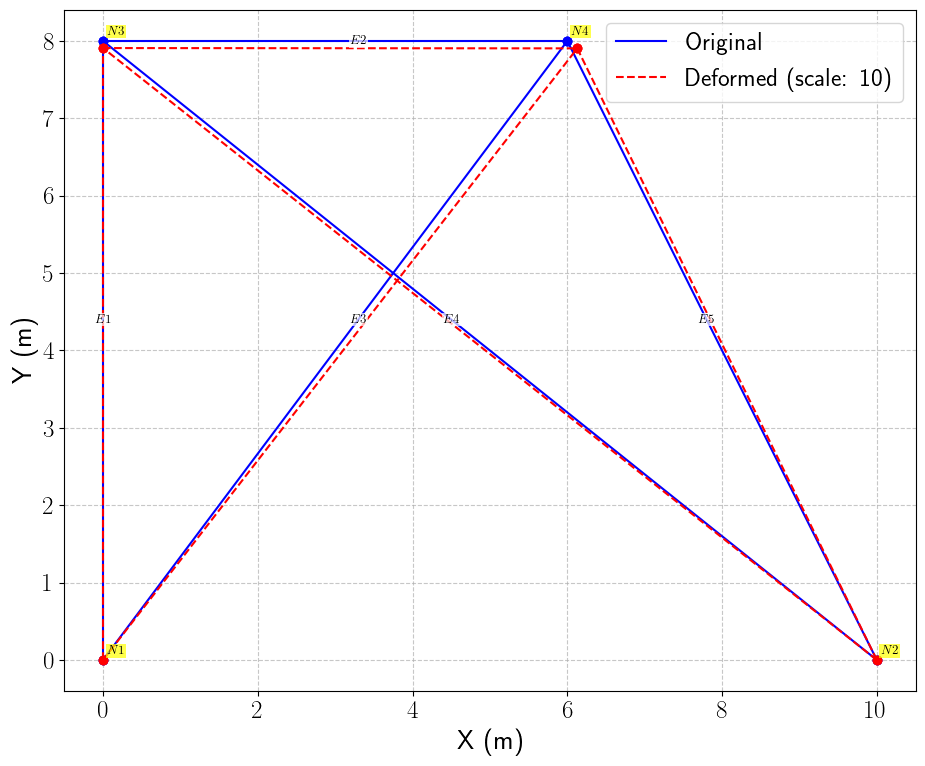

In [7]:
# Plot the obtained solution by amplifying the displacements
from src.plot_mesh import plot_truss_structure

fig, ax = plt.subplots(figsize=(12, 8))
ax = plot_truss_structure(coordinates, connectivity_table, ax=ax, 
        show_element_labels=True,
        show_node_labels=True,
        color='blue',
        linestyle='o-',
        label='Original',
        xlabel='X (m)',
        ylabel='Y (m)',)

scale = 10
deformed_coordinates = coordinates + scale * u_all_1.reshape(-1, 2)
ax = plot_truss_structure(deformed_coordinates, connectivity_table, ax=ax, color='red',
        linestyle='o--',
        show_element_labels=False,
        show_node_labels=False,
        label=f'Deformed (scale: {scale})')
plt.tight_layout()
plt.show()

Then we can reconstruct the displacements and reaction forces at each node and find the axial force in each element

In [ ]:
from src.compute_strains_forces_truss import compute_strains_forces_truss_2d

f_all_1 = K @ u_all_1

axial_strains_1, axial_forces_1 = compute_strains_forces_truss_2d(coordinates, \
                                                    connectivity_table, u_all_1, EA)

for ii in range(n_elements):
    print(f"Local axial force element {ii+1} in [kN]: \n {axial_forces_1[ii]}")

In [ ]:
# Second load case 

dict_forces_2 = {4: np.array([1500, 0])}

f_2 = np.zeros(n_dofs)

for node, force_node in dict_forces_2.items():
    node_id = node - 1
    f_2[2*node_id:2*node_id+2] = force_node

f_red_2 = f_2[dofs_no_bcs]

u_red_2 = spsolve(K_red, f_red_2)
reactions_2 = K[dofs_bcs, :][:, dofs_no_bcs] @ u_red_2

print(f"Displacement at these nodes [mm]:\n {u_red_2*1e3}\n")
print(f"Reactions at bcs in [kN]:\n {reactions_2}\n")

In [ ]:
u_all_2 = np.zeros(n_dofs)
u_all_2[dofs_no_bcs] = u_red_2
f_all_2 = K @ u_all_2

axial_strains_2, axial_forces_2 = compute_strains_forces_truss_2d(coordinates, \
                                                    connectivity_table, u_all_2, EA)

axial_stress_2 = E * axial_strains_2

for ii in range(n_elements):
    print(f"Local axial force element {ii+1}: \n {axial_forces_2[ii]}")

In [8]:
# Optimization of truss sections given yield stress and safety factor to be done.

sigma_max = 200 # [MPa]

